In [1]:
# сэмплим слова из комутатора, и из групп
# протсо обучаем классификатор, лежит в этом комутаторе или не лежит
# тест другой длины

In [3]:
import sys

sys.path.append('..')
import pickle
from os import environ
from pathlib import Path

import pandas as pd
import torch
import wandb
from lming.utils import download_artifact
from sklearn.model_selection import train_test_split
from tokenizer import build_tokenizer
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import (AutoModelForSequenceClassification, BertConfig,
                          Trainer, TrainingArguments)
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
environ['WANDB_USERNAME']='pavel-tikhomirov'
environ['WANDB_DIR']=f'/main/whitehead/{environ["WANDB_USERNAME"]}-runs/'
environ['TOKENIZERS_PARALLELISM']='false'

### PREPARE MODEL

In [6]:
tokenizer = build_tokenizer('word-level', fdim=3, add_commutator_tokens=True,
                            add_prompt_tokens=True, add_post_processor=True)

/usr/local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
config = BertConfig(
    vocab_size = len(tokenizer.get_vocab()),
    hidden_size = 768,
    num_hidden_layers = 8,
    num_attention_heads = 6,
    intermediate_size = 512,
    num_labels=2,
    bos_token_id = tokenizer.bos_token_id,
    eos_token_id = tokenizer.eos_token_id,
    pad_token_id = tokenizer.pad_token_id,
)

### PREPARE DATA

In [8]:
run = wandb.init(entity='ml-in-algebraic-topology', project='whitehead')
artifact_dir = download_artifact('fdim-3-whitehead:v4')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact fdim-3-whitehead:v4, 167.68MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.5


In [9]:
wandb.finish()

In [ ]:
with open(Path(artifact_dir) / "train.pkl", 'rb') as f:
    train_data = pickle.load(f)

In [11]:
with open(Path(artifact_dir) / "val.pkl", 'rb') as f:
    val_data = pickle.load(f)

In [12]:
data = train_data + val_data

In [13]:
def process_word(word):
    return {
        'word_str': word['word_str'].split(':')[1],
        'label': int(word['label'] == 'c'),
        'len': len(word['word_str'].split(':')[1].split())
        }

In [14]:
data_processed = list(map(process_word, tqdm(data)))

100%|██████████| 800000/800000 [00:03<00:00, 260679.02it/s]


In [15]:
train_data_processed = list(map(process_word, tqdm(train_data)))
val_data_processed = list(map(process_word, tqdm(val_data)))

100%|██████████| 600844/600844 [00:02<00:00, 279455.59it/s]


In [16]:
def collate_classification_train(batch):
    collated_batch = tokenizer([el['word_str'] for el in batch],
                      padding=True, return_tensors='pt',
                      return_token_type_ids=False)
    collated_batch['labels'] = torch.tensor([el['label'] for el in batch])
    return collated_batch

In [17]:
df = pd.DataFrame(data_processed)
df_train = pd.DataFrame(train_data_processed)
df_val = pd.DataFrame(val_data_processed)

In [18]:
min_com_length = df[['label', 'len']].groupby('label').min().loc[1].item()

In [19]:
max_common_length = df[['label', 'len']].groupby('label').max().min().item()

In [20]:
MAX_LEN_THRESHOLD = 90
test_no_com_small_length = df[df.len < min_com_length]
df_main = df_train[df_train.len <= MAX_LEN_THRESHOLD]
test_big_length = df_train[df_train.len > MAX_LEN_THRESHOLD]
test_only_com = df_val[df_val.len > max_common_length]

In [21]:
test_big_length.label.value_counts()

label
0    31383
1    10461
Name: count, dtype: int64

In [22]:
train, val = train_test_split(df_main, stratify=df_main.label, test_size=0.1)

<Axes: xlabel='len', ylabel='Count'>

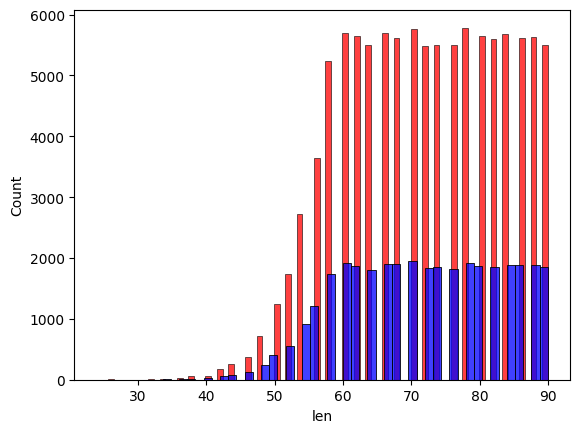

In [23]:
sns.histplot(train[train.label==0].len, color='red')
sns.histplot(train[train.label==1].len, color='blue')

<Axes: xlabel='len', ylabel='Count'>

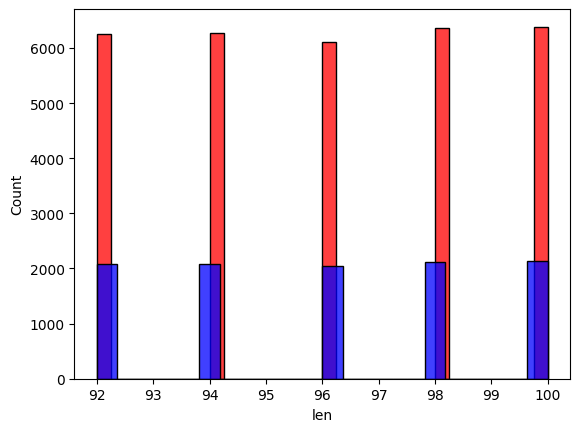

In [24]:
sns.histplot(test_big_length[test_big_length.label==0].len, color='red')
sns.histplot(test_big_length[test_big_length.label==1].len, color='blue')

In [25]:
class CustomDataset(Dataset):
    def __init__(self, df) -> None:
        super().__init__()
        self.df = df
    
    def __getitem__(self, index):
        return self.df.iloc[index].to_dict()
    
    def __len__(self):
        return len(self.df)

In [26]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)
test_no_com_small_length_dataset = CustomDataset(test_no_com_small_length)
test_big_length_dataset = CustomDataset(test_big_length)
test_only_com_dataset = CustomDataset(test_only_com)

In [27]:
train_dataloader = DataLoader(train_dataset, batch_size=256, collate_fn=collate_classification_train, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, collate_fn=collate_classification_train, shuffle=False)

test_no_com_small_length_dataloader = DataLoader(test_no_com_small_length_dataset, batch_size=256, collate_fn=collate_classification_train, shuffle=False)
test_big_length_dataloader = DataLoader(test_big_length_dataset, batch_size=256, collate_fn=collate_classification_train, shuffle=False)
test_only_com_dataloader = DataLoader(test_only_com_dataset, batch_size=256, collate_fn=collate_classification_train, shuffle=False)

In [28]:
test_dataloaders = dict(
    val=val_dataloader,
    test_no_com_small_length=test_no_com_small_length_dataloader,
    test_big_length=test_big_length_dataloader,
    test_only_com=test_only_com_dataloader
)

In [29]:
import numpy as np
from sklearn.metrics import accuracy_score

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return accuracy_score(labels, predictions)

In [31]:
import torch
from torch.utils.tensorboard import SummaryWriter
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import wandb
from torch.optim import AdamW


In [33]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [34]:
def train_one_epoch(model, loader, loader_name, optimizer,criterion, epoch,
                    scheduler=None, train=True, writer=None, return_res=False):
    total_loss = 0
    num_samples = 0
    predictions = []
    labels = []
    if train:
        model.train()
    else:
        model.eval()
    
    for batch in loader:
        batch = batch.to(device)
        if train:
            optimizer.zero_grad()
            outputs = model(**batch)
            outputs = model(input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'])
            logits = outputs.logits
            loss = criterion(logits, batch['labels'])

            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
        else:
            with torch.no_grad():
                outputs = model(**batch)
                outputs = model(input_ids=batch['input_ids'],
                            attention_mask=batch['attention_mask'])
                logits = outputs.logits
                loss = criterion(logits, batch['labels'])

        _, predicted = torch.max(logits, 1)
        predictions.extend(predicted.cpu().numpy())
        labels.extend(batch['labels'].cpu().numpy())
        num_samples += batch['labels'].size(0)

    total_loss /= num_samples
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    total_loss += loss.item()

    if writer:
        writer.add_scalar(f'Loss/{loader_name}', total_loss, epoch)
        writer.add_scalar(f'Accuracy/{loader_name}', accuracy, epoch)
        writer.add_scalar(f'Precision/{loader_name}', precision, epoch)
        writer.add_scalar(f'Recall/{loader_name}', recall, epoch)
    
    if return_res:
        return labels, predictions

In [ ]:
writer = SummaryWriter(filename_suffix='10-12-2024_balanced')
model = AutoModelForSequenceClassification.from_config(config).to(device)
num_epochs = 2
total_steps = len(train_dataloader) * num_epochs

# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-6, weight_decay=0.01)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=total_steps//20, num_training_steps=total_steps)
scheduler = None
   # Class weights (placeholder example, adjust according to your data)
class_weights = torch.tensor([0.4, 0.6]).to(device)
# class_weights = None
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, reduction='sum')

for epoch in tqdm(range(num_epochs)):
    # Training
    train_one_epoch(model, train_dataloader, 'train',
                    optimizer, criterion, epoch,
                    scheduler, writer=writer)
    for data_loader_name, data_loader in test_dataloaders.items():
        train_one_epoch(model, data_loader, data_loader_name,
                        optimizer, criterion, epoch, scheduler,
                        train=False, writer=writer)


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 50%|█████     | 1/2 [04:36<04:36, 276.23s/it]/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 2/2 [09:14<00:00, 277.23s/it]


In [ ]:
SGD: momentum=0.9

9

In [37]:
from torch.optim import SGD
from schedulefree import SGDScheduleFree

In [43]:
opt_str2class = {
    'SGD': SGD,
    'SGDScheduleFree': SGDScheduleFree
}
optimizers= {
    'SGD': {'momentum': [0, 0.9]},
    'SGDScheduleFree': {'momentum': [0, 0.9]},
}

In [ ]:
LR_DEFAULT = 3e-4

for optimizer_name, optimizer_class in opt_str2class.items():
    params = optimizers[optimizer_name]
    kwargs_list = []
    for param, values in params.items():
        for value in values:
            kwargs_list.append({param: value})

    for kwargs in kwargs_list:
        optimizer = optimizer_class(model.parameters(), lr=LR_DEFAULT, **kwargs)

In [ ]:
writer = SummaryWriter(filename_suffix='10-12-2024_balanced')
model = AutoModelForSequenceClassification.from_config(config).to(device)
num_epochs = 2
total_steps = len(train_dataloader) * num_epochs

# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-6, weight_decay=0.01)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=total_steps//20, num_training_steps=total_steps)
scheduler = None
   # Class weights (placeholder example, adjust according to your data)
class_weights = torch.tensor([0.4, 0.6]).to(device)
# class_weights = None
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, reduction='sum')

for epoch in tqdm(range(num_epochs)):
    # Training
    train_one_epoch(model, train_dataloader, 'train',
                    optimizer, criterion, epoch,
                    scheduler, writer=writer)
    for data_loader_name, data_loader in test_dataloaders.items():
        train_one_epoch(model, data_loader, data_loader_name,
                        optimizer, criterion, epoch, scheduler,
                        train=False, writer=writer)